## Walkthrough notebook for the Simple Solver
Perform rotation and offset corrections on the reference 2D trace profiles and wavelength maps to match an input GR700XD/CLEAR dataframe.

In [1]:
import sys
ss_path = '/Users/michaelradica/Documents/GitHub/jwst-mtl/'
sys.path.insert(0, ss_path)

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

from SOSS.dms import soss_centroids as ctd
from SOSS.dms import soss_solver as ss
from SOSS.extract import soss_read_refs
#soss_read_refs.PATH = '/home/talens-irex/Dropbox/SOSS_Ref_Files'
soss_read_refs.PATH = '/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/SOSS_Ref_Files/'

Use the CV3 CLEAR deepstack as a test case.

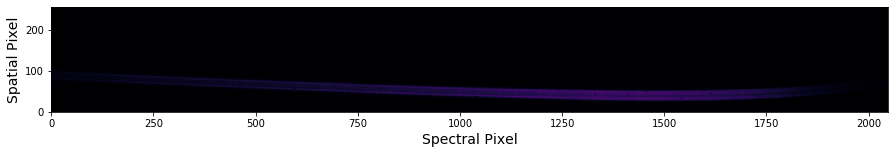

In [40]:
# Open the CV3 SUBSTRIP256 CLEAR exposure.
#filepath = '/home/talens-irex/Downloads/stack_256_ng3_DMS.fits'
filepath = '/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/cv3_clear.fits'
clear = fits.open(filepath)[0].data[::-1, :]

# Fix NaN edge columns
for i in range(4):
    clear[:, i] = clear[:, 4]
    clear[:, 2044 + i] = clear[:, 2043]

# Create bad pixel mask.
badpix = ~np.isfinite(clear)

# Fill in bad pixels, for display purposes.
clear[badpix] = 0

# Add some exaggerated shift and rotation, for testing purposes.
# Comment for a more realistic example.
clear = ss.transform_image(-2.5, 50, 8, clear)

plt.figure(figsize=(15, 3))
plt.imshow(clear, origin='lower', cmap='inferno', interpolation='None', vmin=0)
plt.xlabel('Spectral Pixel', fontsize=14)
plt.ylabel('Spatial Pixel', fontsize=14)
plt.show()

Finding the reference-to-data transformation is simple.

In [23]:
# Read the X & Y positions of the reference trace.
table = soss_read_refs.RefTraceTable()
_, xref = table('X')
_, yref = table('Y')

# Find the transformation (rotation angle, X-offset, Y-offset) required to match
# the reference trace to the data.
simple_transform = ss.solve_transform(clear, badpix, xref, yref, 'SUBSTRIP256')

print('angle: {0:.2f}deg\nX-offset: {1:.2f}pix\nY-offset: {2:.2f}pix'.format(*simple_transform))

angle: 2.65deg
X-offset: 55.67pix
Y-offset: 6.90pix


Apply the transformation to a wavelength map and a trace profile.

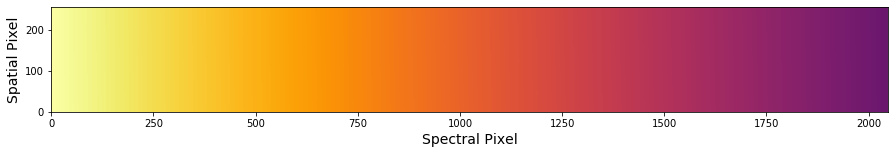

In [34]:
# Read in the reference 2D wavelength map, with padding and oversampling info.
profile = soss_read_refs.Ref2dWave()
wave_map, ovs, pad = profile(order=1, native=False, only_prof=False)

# Add extra padding to deal with the exaggerated shift and rotation.
pad += 100
wave_map = np.pad(wave_map, 100*ovs)

# Apply the transformation.
wave_map = ss.apply_transform(simple_transform, wave_map, ovs, pad)

# Plot the results.
plt.figure(figsize=(15, 3))
plt.imshow(wave_map, origin='lower', cmap='inferno', interpolation='None', vmin=0)
plt.xlabel('Spectral Pixel', fontsize=14)
plt.ylabel('Spatial Pixel', fontsize=14)
plt.show()

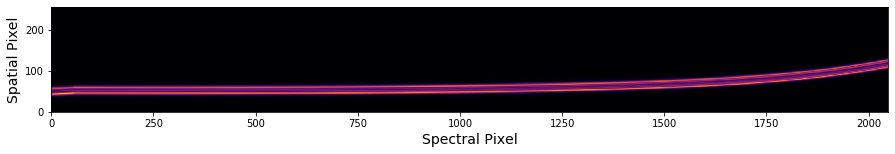

In [38]:
# Read in the reference 2D trace profile, with padding and oversampling info.
profile = soss_read_refs.Ref2dProfile()
profile_map, ovs, pad = profile(order=1, native=False, only_prof=False)
    
# Add extra padding to deal with the exaggerated shift and rotation.
ex_pad = 100
pad += ex_pad
profile_map = np.pad(profile_map, ex_pad*ovs)
# Fill in the padding to avoid large artifacts.
for i in range(20 + ex_pad*ovs):
    profile_map[:, i] = profile_map[:, 21+ex_pad*ovs]
    profile_map[:, -i] = profile_map[:, -21-ex_pad*ovs]

# Apply the transformation.
profile_map = ss.apply_transform(simple_transform, profile_map, ovs, pad, norm=True)

plt.figure(figsize=(15, 3))
plt.imshow(profile_map, origin='lower', cmap='inferno', interpolation='None', vmin=0, vmax=0.1)
plt.xlabel('Spectral Pixel', fontsize=14)
plt.ylabel('Spatial Pixel', fontsize=14)
plt.show()

The trace discontinuity at small X values is simply due to the hack used to create the padding.

### SUBSTRIP96

/Users/michaelradica/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/michaelradica/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


Text(0, 0.5, 'Spatial Pixel')

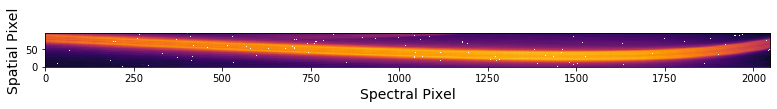

In [41]:
# Trim SUBSTRIP256 CV3 data to SUBSTRIP96.
clear96 = clear[10:-150, :]
badpix96 = badpix[10:-150, :]

plt.figure(figsize=(13, 5))
plt.imshow(np.log10(clear96), origin='lower', cmap='inferno')

plt.xlabel('Spectral Pixel', fontsize=14)
plt.ylabel('Spatial Pixel', fontsize=14)

In [42]:
# Read the reference positions.
table = soss_read_refs.RefTraceTable()
_, xref = table('X', subarray='SUBSTRIP96')
_, yref = table('Y', subarray='SUBSTRIP96')

# Find the transformation.
simple_transform = ss.solve_transform(clear96, badpix96, xref, yref, 'SUBSTRIP96')

print('angle: {0:.2f}deg\nX-offset: {1:.2f}pix\nY-offset: {2:.2f}pix'.format(*simple_transform))

angle: 0.15deg
X-offset: 5.56pix
Y-offset: -1.38pix


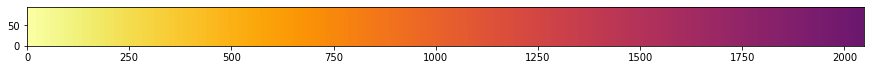

In [43]:
profile = soss_read_refs.Ref2dWave()
wave_map, ovs, pad = profile(order=1, native=False, only_prof=False, subarray='SUBSTRIP96')

# Some extra padding to deal with the exxagerated shift and rotation.
pad = pad + 100
wave_map = np.pad(wave_map, 100*ovs,)

# Apply the transformation.
wave_map = ss.apply_transform(simple_transform, wave_map, ovs, pad)

plt.figure(figsize=(15, 3))
plt.imshow(wave_map, origin='lower', cmap='inferno', interpolation='None', vmin=0)
plt.show()

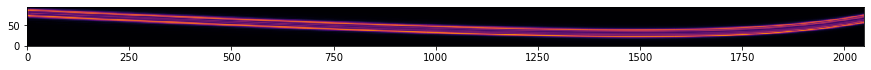

In [44]:
profile = soss_read_refs.Ref2dProfile()
profile_map, ovs, pad = profile(order=1, native=False, only_prof=False, subarray='SUBSTRIP96')

# Some extra padding to deal with the exaggerated shift and rotation.
pad = pad + 100
profile_map = np.pad(profile_map, 100*ovs)

# Apply the transformation.
profile_map = ss.apply_transform(simple_transform, profile_map, ovs, pad, norm=True)

plt.figure(figsize=(15, 3))
plt.imshow(profile_map, origin='lower', cmap='inferno', interpolation='None', vmin=0, vmax=0.1)
plt.show()

### FULL

/Users/michaelradica/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/michaelradica/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


Text(0, 0.5, 'Spatial Pixel')

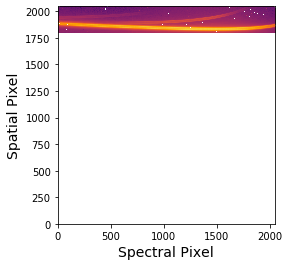

In [45]:
# Extend the SUBSTRIP256 CV3 data to the dimensions of FULL.
clearFULL = np.zeros((2048, 2048))
clearFULL[-256:, :] = clear
badpixFULL = np.zeros((2048, 2048), dtype='bool')
badpixFULL[-256:, :] = badpix

plt.imshow(np.log10(clearFULL), origin='lower', cmap='inferno')

plt.xlabel('Spectral Pixel', fontsize=14)
plt.ylabel('Spatial Pixel', fontsize=14)

In [46]:
# Read the reference positions.
table = soss_read_refs.RefTraceTable()
_, xref = table('X', subarray='FULL')
_, yref = table('Y', subarray='FULL')

# Find the transformation.
simple_transform = ss.solve_transform(clearFULL, badpixFULL, xref, yref, 'FULL')

print('angle: {0:.2f}deg\nX-offset: {1:.2f}pix\nY-offset: {2:.2f}pix'.format(*simple_transform))

angle: 0.15deg
X-offset: 10.29pix
Y-offset: -1.37pix


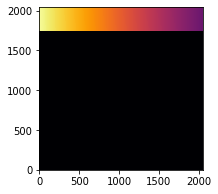

In [47]:
profile = soss_read_refs.Ref2dWave()
wave_map, ovs, pad = profile(order=1, native=False, only_prof=False, subarray='FULL')

# Some extra padding to deal with the exaggerated shift and rotation.
pad = pad + 100
wave_map = np.pad(wave_map, 100*ovs)

# Apply the transformation.
wave_map = ss.apply_transform(simple_transform, wave_map, ovs, pad)

plt.figure(figsize=(15, 3))
plt.imshow(wave_map, origin='lower', cmap='inferno', interpolation='None', vmin=0)
plt.show()

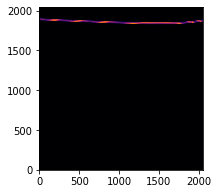

In [48]:
profile = soss_read_refs.Ref2dProfile()
profile_map, ovs, pad = profile(order=1, native=False, only_prof=False, subarray='FULL')

# Some extra padding to deal with the exaggerated shift and rotation.
pad = pad + 100
profile_map = np.pad(profile_map, 100*ovs)

# Apply the transformation.
profile_map = ss.apply_transform(simple_transform, profile_map, ovs, pad, norm=True)

plt.figure(figsize=(15, 3))
plt.imshow(profile_map, origin='lower', cmap='inferno', interpolation='None', vmin=0, vmax=0.1)
plt.show()